## astropy.modeling solutions

### Exercise 1:

#Generate fake data
```
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
```
- Fit the data with a Trapezoid1D model.
- Fit a Gaussian1D model to it.
- Display the results.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

from astropy.modeling import models, fitting

Create the data.

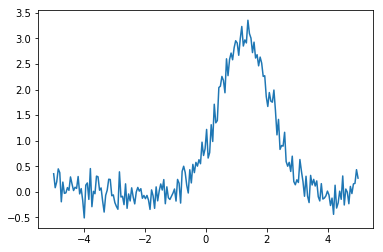

In [2]:
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)
plt.plot(x, y)

Let's see what the parameter names for Trapezoi1D are.

In [3]:
print(models.Trapezoid1D.param_names)

('amplitude', 'x_0', 'width', 'slope')


Create a Trapezoid1D model - the prameter values will be used as initial guesses for the fitting.

In [4]:
trapez_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5)

Fit the model to the data. The output is a new model - `trapez`.

In [5]:
fitter = fitting.LevMarLSQFitter()
trapez = fitter(trapez_init, x, y)
print(trapez.parameters)

[3.05157498 1.27236833 0.31699956 1.82510002]


In a similar way fit a Gaussian to the data.

In [6]:
gauss_init = models.Gaussian1D(amplitude=1, mean=0, stddev=1)
gauss = fitter(gauss_init, x, y)
print(gauss.parameters)

[3.04705247 1.27430146 0.81353503]


Diplay the results.

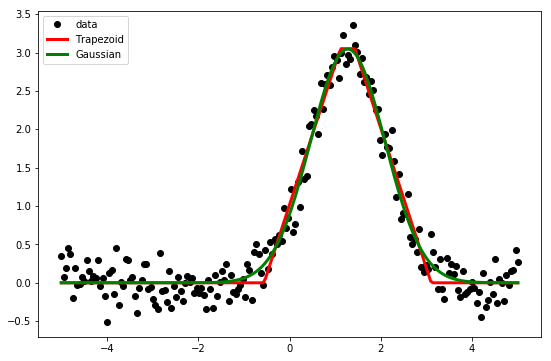

In [7]:
plt.figure(figsize=(9,6))
plt.plot(x, y, 'ko', label='data')
plt.plot(x, trapez(x), 'r', label='Trapezoid', lw=3)
plt.plot(x, gauss(x), 'g', label='Gaussian', lw=3)
plt.legend(loc=2)

Exercise 2:

- read a spectrum from a text file (./sample_sdss.txt)
- Using the rest wavelengths as initial values, fit a gaussian to the H beta and OIII lines.


In [8]:
from astropy.io import ascii
sdss = ascii.read('./sample_sdss.txt')
sdss.colnames

['lambda', 'flux', 'err', 'tem']

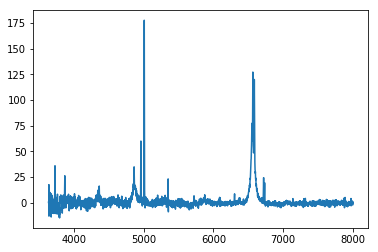

In [9]:
wave = sdss['lambda']
flux = sdss['flux']
#%matplotlib notebook
plt.plot(wave, flux)

Use the rest wavelengths as initial values for the locaiton of the lines.


In [10]:
Hbeta = 4862.721
Halpha = 6564.614
OIII_1 = 4958.911
OIII_2 = 5008.239
Na = 6549.86
Nb = 6585.27
Sa = 6718.29
Sb = 6732.68

Text(6700, 70, 'Sa and Sb')

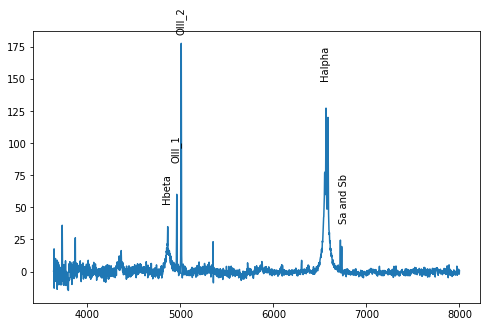

In [11]:
wave = sdss['lambda']
flux = sdss['flux']
plt.figure(figsize=(8, 5))
plt.plot(wave, flux)
plt.text(4800, 70, 'Hbeta', rotation=90)
plt.text(4900, 100, 'OIII_1', rotation=90)
plt.text(4950, 200, 'OIII_2', rotation=90)
plt.text(6500, 170, 'Halpha', rotation=90)
plt.text(6700, 70, 'Sa and Sb', rotation=90)

Create a Polynomial model to fit the continuum.

In [12]:
mean_flux = flux.mean()
cont = np.where(flux > mean_flux, mean_flux, flux)
linfitter = fitting.LinearLSQFitter()
poly_cont = linfitter(models.Polynomial1D(1), wave, cont)
print(poly_cont)

Model: Polynomial1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Degree: 1
Parameters:
             c0                   c1         
    ------------------- ---------------------
    -0.8012383558421305 9.797316295780924e-05


Create Gaussin1D models for each of the Hbeta and OIII lines.

In [13]:
h_beta = models.Gaussian1D(amplitude=34, mean=Hbeta, stddev=5)
o3 = models.Gaussian1D(amplitude=170, mean=OIII_2, stddev=5)
o1 = models.Gaussian1D(amplitude=57, mean=OIII_1, stddev=5)

Create a compound model for the three lines and the continuum.

In [14]:
hbeta_combo = h_beta + o1 + o3 + poly_cont
print(hbeta_combo.param_names)

('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1', 'amplitude_2', 'mean_2', 'stddev_2', 'c0_3', 'c1_3')


Tie the ratio of the intensity of the two OIII lines.

In [15]:
def tie_ampl(model):
    return model.amplitude_2 / 3.1

hbeta_combo.amplitude_1.tied = tie_ampl

Also tie the wavelength of the Hbeta line to the OIII wavelength.

In [16]:
def tie_wave(model):
    return model.mean_0 * OIII_1/Hbeta

hbeta_combo.mean_1.tied = tie_wave 

Fit all lines simultaneously.

In [17]:
fitter = fitting.LevMarLSQFitter()
fitted_model = fitter(hbeta_combo, wave, flux)
fitted_lines = fitted_model(wave)

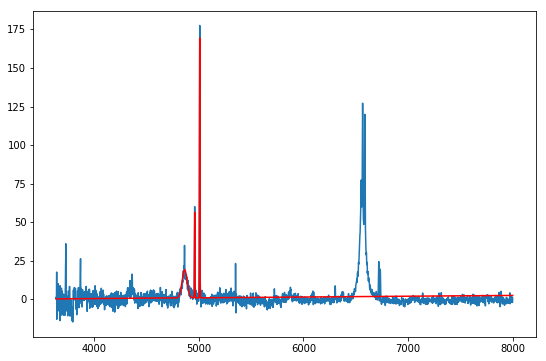

In [18]:
plt.figure(figsize=(9, 6))
plt.plot(wave, flux)
plt.plot(wave, fitted_lines, 'r')